## Analyzing Aggravated Burglaries in Davidson County

### Part 1 - Data Gathering using APIs

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents () that were reported during the nine month period from January 1, 2022 through September 30, 2022. (Hint: Check out the API Docs to see how to narrow down the response to just the desired results).

In [69]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
import json
from shapely.geometry import Point
import shapely
import numpy as np
from scipy.stats import poisson
from ipywidgets import interact, FloatSlider, IntSlider
import statsmodels.api as sm
import statsmodels.formula.api as smf

Reading the API, I figured out I need the NIBRS code (https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes).
For burglary it is 220 and checking it on the webpage:


It looks like this is what I'm looking for and the 'offense description' isn't always consistent. Will have to check which ones have 'aggravated' in there:
https://data.nashville.gov/resource/2u6v-ujjs.json?offense_nibrs=220

The code below just connects to the API and gets the requested type (burglary/breaking and entering)

In [2]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.json'

params = {
    '$where' : "incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'",
    'offense_nibrs' : 220,
    '$limit' : 5000
}

response = requests.get(endpoint, params = params)
response


<Response [200]>

In [3]:
len(response.json())

3530

In [4]:
incidents_df = pd.DataFrame(response.json())

In [5]:
# I used this before I figured out how to do it with regex
# incidents_df[incidents_df['offense_description'].str.upper().str.find('AGGRAVATED') != -1]

the below code is to get all the burglaries that contain at least agg (shorthand for AGGRAVATED). Comparing it to the output with my previous code I found out that the word AGGRAVATED was never actually abbreviated in the file

In [6]:
incidents_df = incidents_df[incidents_df['offense_description'].str.match(r'.+[aA][gG][gG].+') == True]

In [7]:
incidents_df['offense_description'].unique()

array(['BURGLARY- AGGRAVATED', 'BURGLARY - AGGRAVATED',
       'Burglary - Aggravated - Acting in Concert',
       'BURGLARY - ESPECIALLY AGGRAVATED',
       'BURGLARY - AGGRAVATED - ACTING IN CONCERT'], dtype=object)

2. Using the 2020 American Community Survey API (https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37.

First off, loading my key for the census data API!

In [8]:
with open('../keys.json') as fi:
    credentials = json.load(fi)

In [9]:
api_key = credentials['api_key']

> note: the documentation for how to construct the API request (for detailed tables) is found here: https://api.census.gov/data/2020/acs/acs5/examples.html

In [10]:
endpoint = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:47&in=county:037&key={api_key}'


response = requests.get(endpoint)
response

<Response [200]>

In [11]:
pop_df = pd.DataFrame(response.json())

In [12]:
pop_df = (
    pop_df
    .rename(columns=pop_df.iloc[0])
    .drop(pop_df.index[0])
    .rename(columns={'B01001_001E':'population'})
)

Similar but different, Subject Tables now. 

In [13]:
endpoint = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S1901_C01_012E&for=tract:*&in=state:47&in=county:037&key={api_key}'


response = requests.get(endpoint)
response

<Response [200]>

In [14]:
med_income_df = pd.DataFrame(response.json())

In [15]:
med_income_df = (
    med_income_df
    .rename(columns=med_income_df.iloc[0])
    .drop(med_income_df.index[0])
    .rename(columns={'S1901_C01_012E':'median_income'})
)

Did a .head() and .count() command to make sure both tables have the same length (as they should, 174); after the merge below the number was the same (as it of course should).

In [16]:
pop_med_income_df = pd.merge(pop_df, med_income_df, "inner", on=['NAME', 'state', 'county', 'tract'])

### Part 2 - Spatial Joining and Data Merging

3. Download the 2020 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred.

In [17]:
tract_geo = gpd.read_file('../data/tl_2020_47_tract/tl_2020_47_tract.shp')

In [18]:
tract_geo.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,175,925200,47175925200,9252,Census Tract 9252,G5020,S,227429512,1667739,+35.7438100,-085.4940227,"POLYGON ((-85.61516 35.76106, -85.61509 35.761..."
1,47,175,925000,47175925000,9250,Census Tract 9250,G5020,S,480712883,1225717,+35.6695378,-085.4220628,"POLYGON ((-85.60513 35.70854, -85.60511 35.708..."


In [19]:
# incidents_df.info
incidents_df.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'location_code', 'location_description',
       'offense_number', 'offense_nibrs', 'offense_description',
       'weapon_primary', 'weapon_description', 'victim_number',
       'domestic_related', 'victim_type', 'victim_description',
       'victim_gender', 'victim_race', 'victim_ethnicity',
       'victim_county_resident', 'mapped_location', 'rpa', 'zone', 'zip_code'],
      dtype='object')

Note: at first I tried to use the 'mapped_location' to turn it into a point. However, both doing a list comprehension like this:
> x['coordinates'] for x in incidents_df['mapped_location'])

or, expanding the dictionary first with 
> incidents_df.mapped_location.apply(pd.Series)['coordinates']

and then trying to unpack the remaining list with a lambda-function
> incidents_df['lnglat'].apply(lambda x: x[0])

none of it was working. The error was 'float' is not subsciptible. Michael helped me figure out that some rows had NaNs, which is what caused that error. So, the code commented below works.

In [20]:
# working code, have to do an if statement to skip nans
# incidents_df['lat'] = (
#     [x['coordinates'][0] 
#      if x is not np.nan 
#      else None 
#      for x in incidents_df['mapped_location']]    
#)

In [21]:
# note: we decided it was easier to drop duplicate incidents BEFORE doing the spatial merge
incidents_df = incidents_df.drop_duplicates(subset='incident_number')

In [22]:
incidents_df['geometry'] = gpd.points_from_xy(
    incidents_df['longitude'], incidents_df['latitude'])

In [23]:
incidents_geo = gpd.GeoDataFrame(incidents_df, crs = tract_geo.crs, geometry = incidents_df['geometry'])

In [24]:
# has to be a right join so that we keep all tracts even with no burglaries within
incidents_by_tract = gpd.sjoin(incidents_geo, tract_geo, how='right', predicate = 'within')

In [25]:
incidents_by_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2793 entries, 0 to 1700
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   index_left                   1257 non-null   float64 
 1   primary_key                  1257 non-null   object  
 2   incident_number              1257 non-null   object  
 3   report_type                  1257 non-null   object  
 4   report_type_description      1246 non-null   object  
 5   incident_status_code         1257 non-null   object  
 6   incident_status_description  1257 non-null   object  
 7   investigation_status         1257 non-null   object  
 8   incident_occurred            1257 non-null   object  
 9   incident_reported            1257 non-null   object  
 10  incident_location            1250 non-null   object  
 11  latitude                     1257 non-null   object  
 12  longitude                    1257 non-null   object  


4. Aggregate the data by census tract. Warning: each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents. Which census tract had the highest number of burglaries? Which census tract had the highest number of burglaries per 1000 residents? Note: Make sure that you keep all census tracts, not just those that have had a burglary.

> highest number of burglaries -> tract # 143; to answer the other question, see point 5. as we need to get the population in

In [26]:
incidents_by_tract.groupby('TRACTCE')['incident_number'].count().nlargest(3)

TRACTCE
014300    41
016300    37
016000    30
Name: incident_number, dtype: int64

In [27]:
# better way to see it than above
incidents_by_tract.groupby('NAMELSAD')['incident_number'].count().nlargest(3)

NAMELSAD
Census Tract 143    41
Census Tract 163    37
Census Tract 160    30
Name: incident_number, dtype: int64

In [28]:
incidents_by_tract.columns

Index(['index_left', 'primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'location_code', 'location_description',
       'offense_number', 'offense_nibrs', 'offense_description',
       'weapon_primary', 'weapon_description', 'victim_number',
       'domestic_related', 'victim_type', 'victim_description',
       'victim_gender', 'victim_race', 'victim_ethnicity',
       'victim_county_resident', 'mapped_location', 'rpa', 'zone', 'zip_code',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [29]:
pop_med_income_df.columns

Index(['NAME', 'population', 'state', 'county', 'tract', 'median_income'], dtype='object')

In [30]:
incidents_by_tract_stats = pd.merge(
    pop_med_income_df, incidents_by_tract,
    how='inner', left_on='tract', right_on='TRACTCE'
)

5. Merge in the census data that you gathered in question 2. Remove any rows that have zero population or negative median income values.

In [31]:
# code below to get rid of zero population and negative med values
incidents_by_tract_stats = incidents_by_tract_stats[(incidents_by_tract_stats['population']).astype(int) > 0] 
incidents_by_tract_stats = incidents_by_tract_stats[(incidents_by_tract_stats['median_income']).astype(float) >= 0]

In [32]:
# new column to have number of incidents per each tract
incidents_by_tract_stats['n_incidents_tract'] = incidents_by_tract_stats.groupby('TRACTCE')['incident_number'].transform('count').to_frame()

In [33]:
# new column to have number of incidents per population
incidents_by_tract_stats['n_incidents_tract_pop'] = incidents_by_tract_stats['n_incidents_tract']/(incidents_by_tract_stats['population']).astype(float)

In [34]:
incidents_by_tract_stats.sort_values('n_incidents_tract_pop', ascending=False)

,NAME_x,population,state,county,tract,median_income,index_left,primary_key,incident_number,report_type,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,n_incidents_tract,n_incidents_tract_pop
670,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,1968.0,20220333300_11,20220333300,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
702,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,1376.0,20220241038_11,20220241038,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
683,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,2328.0,20220082577_11,20220082577,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
684,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,1808.0,20220265813_13,20220265813,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
685,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,3044.0,20220401381_11,20220401381,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,"Census Tract 177.02, Davidson County, Tennessee",5595,47,037,017702,115375,NaN,NaN,NaN,NaN,...,Census Tract 177.02,G5020,S,3296657,0,+36.0995275,-086.7996835,"POLYGON ((-86.81446 36.10502, -86.81403 36.105...",0,0.000000
1171,"Census Tract 179.02, Davidson County, Tennessee",4997,47,037,017902,110689,NaN,NaN,NaN,NaN,...,Census Tract 179.02,G5020,S,4111686,0,+36.0961182,-086.8268546,"POLYGON ((-86.84859 36.09327, -86.84854 36.093...",0,0.000000
1091,"Census Tract 165, Davidson County, Tennessee",4849,47,037,016500,58065,NaN,NaN,NaN,NaN,...,Census Tract 165,G5020,S,1494439,0,+36.1456055,-086.8050100,"POLYGON ((-86.81120 36.15104, -86.81000 36.151...",0,0.000000
1265,"Census Tract 187, Davidson County, Tennessee",3353,47,037,018700,186960,NaN,NaN,NaN,NaN,...,Census Tract 187,G5020,S,19580515,302117,+36.0684470,-086.7931275,"POLYGON ((-86.81646 36.03931, -86.81645 36.039...",0,0.000000


> same answer as before, the tract with most burglaries per population is 143, the second and third change

### Part 3 - Statistical Modeling

6. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. Start with some EDA to look at the relationship between median income and number of aggravated burglaries.

> note: as observed by Monica, we don't really need the incident number; and sice this part is just for the statistical modeling, I'll condense the table with just the needed information in the code below.

In [48]:
tract_aggr_burglary = (
    incidents_by_tract_stats
    .groupby(['TRACTCE', 'population', 'median_income'])
    ['incident_number']
    .count()
    .to_frame()
    .reset_index()
)

In [84]:
tract_aggr_burglary[['median_income', 'population']] = tract_aggr_burglary[['median_income', 'population']].astype(float)
tract_aggr_burglary['burglary_per_1kpop'] = tract_aggr_burglary['incident_number'] * 1000 /tract_aggr_burglary['population']

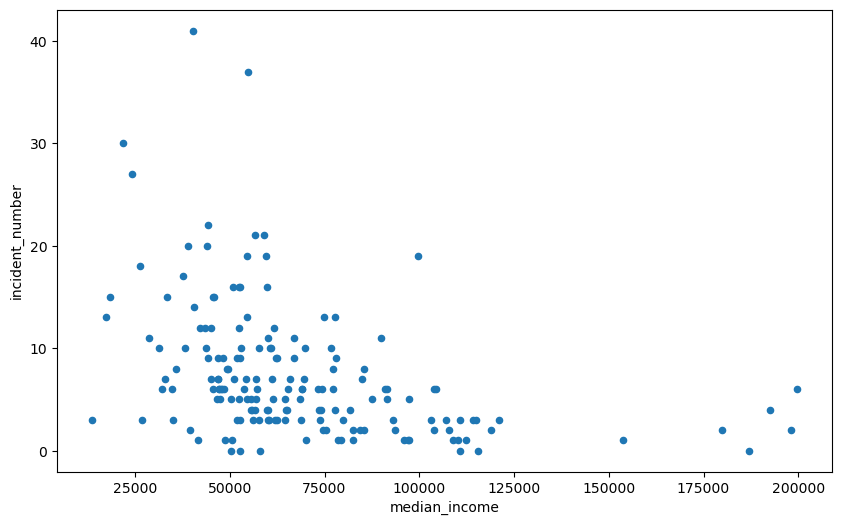

In [81]:
tract_aggr_burglary.plot(
    kind='scatter',
    x='median_income',
    y='incident_number',
    figsize = (10,6));

There appears to be a downward trend. I.e. with higher median income, there appears to be less aggravated burglaries.

In [85]:
ta_summary = (
    tract_aggr_burglary
    .assign(group = pd.qcut(tract_aggr_burglary['median_income'],
                            q = 10,
                           duplicates = 'drop'))
    .groupby('group')
    [['median_income', 'incident_number', 'burglary_per_1kpop']]
    .mean()
    .reset_index()
)

ta_summary

,group,median_income,incident_number,burglary_per_1kpop
0,"(13749.999, 38951.1]",28729.058824,11.882353,4.043676
1,"(38951.1, 46749.6]",43338.411765,13.117647,4.318552
2,"(46749.6, 51028.9]",48479.352941,6.235294,1.364659
3,"(51028.9, 55249.6]",53071.941176,10.411765,3.089588
4,"(55249.6, 60072.0]",57604.647059,8.000000,2.322530
5,"(60072.0, 65577.8]",62374.411765,6.294118,1.697500
6,"(65577.8, 74996.2]",70782.705882,6.058824,1.680802
7,"(74996.2, 85752.0]",80240.058824,4.882353,1.109806
8,"(85752.0, 107205.6]",96926.941176,5.000000,1.104103
9,"(107205.6, 199643.0]",138605.058824,2.000000,0.614862


Similar trends observed as described above

7. Fit a Poisson regression model with target variable the rate of burglaries per census tract and with predictor the median income. Offset using the log of the population so that we are looking at the rate of burglaries per population instead of the number of burglaries. How can you interpret the meaning of the output?

In [86]:
pr_burglary = smf.glm('incident_number ~ I(median_income/1000)',
                 data = tract_aggr_burglary,
                 offset = np.log(tract_aggr_burglary['population']/1000),
                 family = sm.families.Poisson()
                 ).fit()

pr_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -694.61
Date:                Sun, 23 Oct 2022   Deviance:                       800.18
Time:                        10:04:01   Pearson chi2:                 1.22e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7578
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.7565      0.081     21.759      0.000       1.598       1.915
I(median_income / 1000)    -0.0187      0.001    -14.029      0.000      -0.021      -0.016
===========================================================================================
"""

After offsetting for population, and deciding to divide the median income by 1000 (otherwise the factor of changing by a single $ is miniscule) the model estimates that:

$$\text{average number of burglaries} = e^{-5.1513 -0.0187(\text{median income in thousands of UDS)}}$$

In other words, for each $1000 change in median income, the average number of burglaries is predicted to decrease by exp(-0.0187), aka a factor of 0.98147

In [87]:
# using the summary from before (the one with quantiles) to check how good the fit does
ta_summary['fitted'] = pr_burglary.predict(ta_summary)

ta_summary

,group,median_income,incident_number,burglary_per_1kpop,fitted
0,"(13749.999, 38951.1]",28729.058824,11.882353,4.043676,3.388112
1,"(38951.1, 46749.6]",43338.411765,13.117647,4.318552,2.579510
2,"(46749.6, 51028.9]",48479.352941,6.235294,1.364659,2.343505
3,"(51028.9, 55249.6]",53071.941176,10.411765,3.089588,2.150994
4,"(55249.6, 60072.0]",57604.647059,8.000000,2.322530,1.976505
5,"(60072.0, 65577.8]",62374.411765,6.294118,1.697500,1.808153
6,"(65577.8, 74996.2]",70782.705882,6.058824,1.680802,1.545537
7,"(74996.2, 85752.0]",80240.058824,4.882353,1.109806,1.295448
8,"(85752.0, 107205.6]",96926.941176,5.000000,1.104103,0.948767
9,"(107205.6, 199643.0]",138605.058824,2.000000,0.614862,0.435838


**note**: the fitted quantity has to be compared with burglary per capita (also same for the graph below). That is because we **offset** for population in our fit!!!

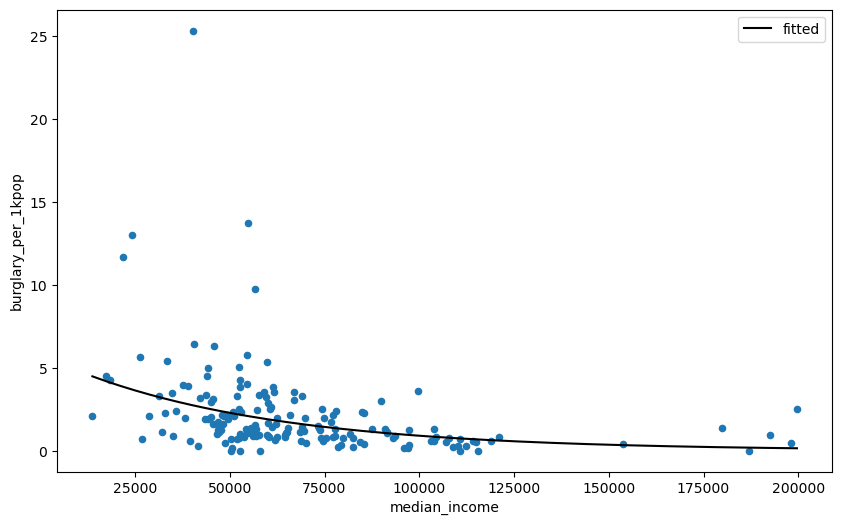

In [88]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(start = tract_aggr_burglary['median_income'].min(),
                      stop = tract_aggr_burglary['median_income'].max(),
                      num = 150)
})
fit_df['fitted'] = pr_burglary.predict(fit_df)

ax = tract_aggr_burglary.plot(x = 'median_income', y = 'burglary_per_1kpop', kind = 'scatter', figsize = (10,6))
fit_df.plot(x = 'median_income', y = 'fitted', color = 'black', ax = ax);

After checking the probabilities in the graph below, I decided to adjust the parameters and have the probabilities be estimated per 1000 people (otherwise the graph is far too squished towards 0).

In [90]:
@interact(median_income = IntSlider(value = 100000, min = tract_aggr_burglary['median_income'].min(), max = tract_aggr_burglary['median_income'].max()))
def fit_plot(median_income):
    
    mu = np.exp(pr_burglary.params['Intercept'] + \
                (median_income/1000) * pr_burglary.params['I(median_income / 1000)'])
    x = np.arange(start = 0, stop = 20, step = 1)
    y = poisson.pmf(x, mu = mu)

    plt.figure(figsize = (10,5))
    plt.bar(x, y, edgecolor = 'black')
    plt.xticks(x)
    plt.xlabel('Number of Burglaries per 1000 people')
    plt.ylabel('Probability')
    plt.title(f'Estimated Distribution of Number of Burglaries per 1000 people\nmedian_income = {median_income} \n$\mu$={round(mu, 3)}');

interactive(children=(IntSlider(value=100000, description='median_income', max=199643, min=13750), Output()), …

8. Bonus: Try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial (https://timeseriesreasoning.com/contents/negative-binomial-regression-model/). How does this model compare to the Poisson model?

Additional Resources for Generalized Linear Models:

- DataCamp - Generalized Linear Models in Python (https://learn.datacamp.com/courses/generalized-linear-models-in-python)
- Beyond Multiple Linear Regression, Chapter 4 (https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html) Warning - the code in this book is all R, but the conceptual explanations are very clear.
- This set of notes (https://apwheele.github.io/MathPosts/PoissonReg.html#negative-binomial-when-the-poisson-does-not-fit), which talks about the problem of overdispersion.